In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mltools import my_convert_to_number, my_convert_to_date
from wordcloud import WordCloud
from collections import Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
pd.set_option("display.max_rows", None, "display.max_columns", None)

sns.set(style="darkgrid")

## Load ODI

In [38]:
odi_df = pd.read_csv('ODI-2022.csv',delimiter=";")


### Number of records

In [39]:
print(len(odi_df.index))

304


### Number of attributes

In [40]:
print(len(odi_df.columns))

17


### Attributes
    

In [41]:
print((odi_df.columns))

Index(['Tijdstempel', 'What programme are you in?',
       'Have you taken a course on machine learning?',
       'Have you taken a course on information retrieval?',
       'Have you taken a course on statistics?',
       'Have you taken a course on databases?', 'What is your gender?',
       'Chocolate makes you.....', 'When is your birthday (date)?',
       'Number of neighbors sitting around you?', 'Did you stand up?',
       'What is your stress level (0-100)?',
       'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? ',
       'Give a random number', 'Time you went to be Yesterday',
       'What makes a good day for you (1)?',
       'What makes a good day for you (2)?'],
      dtype='object')


## Data treatment

### Rename columns

In [42]:
 odi_df.columns = ['time',\
                   'program',\
                   'ML',\
                   'IR',\
                   'Statistics',\
                   'DB',\
                   'Gender',\
               'Chocolate_influence',\
                   'Birthday',\
                   'neighbors',\
                   'Stand_Up',\
                   'stress',\
              'euro_question',\
                   'random_number',\
                   'time_to_bed',\
                   'good_day_1',\
                   'good_day_2']
display(odi_df)

,time,program,ML,IR,Statistics,DB,Gender,Chocolate_influence,Birthday,neighbors,Stand_Up,stress,euro_question,random_number,time_to_bed,good_day_1,good_day_2
0,4-5-2022 12:12:07,artificial intelligence,yes,0,mu,nee,female,neither,02.05.1998,0,no,0,5,888,23:00,coffee,sun
1,4-5-2022 12:12:07,big data,yes,0,mu,nee,male,fat,29-02-2000,0,yes,200,1,12,32,7777,8964
2,4-5-2022 12:12:09,Computational Science,yes,1,mu,ja,male,fat,29-06-1998,1,no,0,100,9,x,0,0
3,4-5-2022 12:12:09,Bioinformatics and Systems Biology,yes,0,unknown,nee,male,neither,11/05/97,0,no,20,100,31,14:00,good food,no stress
4,4-5-2022 12:12:15,AI,yes,1,mu,ja,male,fat,03-10-1997,0,no,2,100,86,07:20,Sunshine,Good Food
5,4-5-2022 12:12:20,Artificial Intelligence,no,unknown,sigma,unknown,female,fat,28,0,no,48,1000,87,2130,This lecture,Sun
6,4-5-2022 12:12:26,Artificial Intelligence,yes,0,unknown,nee,male,neither,15.10.98,1,no,20,0.1,6,00:35,sunshine,happiness
7,4-5-2022 12:12:29,M Artificial Intelligence,yes,0,unknown,ja,male,neither,17 November,0,no,100,10,50,23,Rainy Day,Weekend
8,4-5-2022 12:12:29,FinTech,yes,0,mu,ja,male,neither,1995,0,no,20,100 / the number of people,42,23:00,Food,Relaxation
9,4-5-2022 12:12:29,Artificial Intelligence,no,0,mu,ja,female,fat,21-07-2000,5,yes,50,10,88,12 hours,"sun, friends and wine","relaxing, watching a show, hockey"


### Data conversion to physical values

In [43]:
#treating years as nan when less than Timestamp.min or gretaer than timestamp.max
odi_df['Birthday' ] = pd.to_datetime(odi_df['Birthday' ], errors = 'coerce')
odi_df['time'] = odi_df[['time']].applymap(my_convert_to_date, default=pd.NaT)
odi_df[['random_number', 'stress', 'neighbors', 'euro_question' ]] = odi_df[['random_number', 'stress', 'neighbors', 'euro_question']].applymap(my_convert_to_number)
odi_df[['ML','IR','DB','Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace({"yes", 'ja', "1"}, True)
odi_df[['ML','IR','DB', 'Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace({"no", 'nee', "0"}, False)
odi_df[['ML','IR','DB', 'Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace("unknown", None)
odi_df['time_to_bed' ]= pd.to_datetime(odi_df['time_to_bed' ], errors = 'coerce').dt.hour

mask1 = odi_df['program'].str.contains('tificial|ellig|AI|ai|Ai')
odi_df.loc[mask1,'program'] = 'AI'
mask2 = odi_df['program'].str.contains('Bio|bio|BIO')
odi_df.loc[mask2,'program'] = 'BIO'
mask3 = odi_df['program'].str.contains('Comp|comp|CS|cs')
odi_df.loc[mask3,'program'] = 'CS'
mask4 = odi_df['program'].str.contains('usines|BA')
odi_df.loc[mask4,'program'] = 'BA'
mask5 = odi_df['program'].str.contains('Fin|FIN')
odi_df.loc[mask5,'program'] = 'FINANCE'
mask6 = odi_df['program'].str.contains('conometric|ECONOM')
odi_df.loc[mask6,'program'] = 'ECONOM'

odi_df.loc[(mask1 | mask2 | mask3 | mask4 | mask5 | mask6)==False,'program']='REST'

display(odi_df['program'])
#odi_df['program'] = odi_df['program'].replace({'Masters Computer Science','computational science','Computational Science(CLS)','Computational  Science','MSc Computer Science','MSc Computational Science','Computer Science','Computational Science', 'Computational science'},'CS')
#odi_df['program'] = odi_df['program'].replace({'Bioinformatics and Systems Biology', 'Masters Bioinformatics','Bioinformatics'},'BIO')
#odi_df['program'] = odi_df['program'].replace({'Business Analytics Master (Computational Intel...','Business analytics','Business Analytics'}, 'BA')
#display(odi_df['program'])

0           AI
1         REST
2           CS
3          BIO
4           AI
5           AI
6           AI
7           AI
8      FINANCE
9           AI
10          AI
11          CS
12          AI
13        REST
14          AI
15        REST
16          AI
17          AI
18          AI
19          CS
20     FINANCE
21          CS
22          AI
23          AI
24         BIO
25          CS
26          CS
27          CS
28        REST
29          CS
30          CS
31          AI
32          CS
33          AI
34          AI
35        REST
36          CS
37          AI
38          AI
39          CS
40          AI
41          CS
42          AI
43          AI
44        REST
45          CS
46          CS
47          AI
48         BIO
49          AI
50          CS
51          AI
52          AI
53          CS
54          AI
55          AI
56         BIO
57          CS
58         BIO
59          AI
60          CS
61          AI
62          AI
63        REST
64          CS
65          AI
66        

### age calculation


In [44]:
odi_df['age'] = odi_df['time'] - odi_df['Birthday']
#setting age more than 90 years and less than 10 to None
odi_df['age'] = odi_df['age'].dt.days/365


### Outliers

In [45]:
odi_df.loc[(odi_df['random_number']>=200)|(odi_df['random_number']<0), 'random_number'] = None
odi_df.loc[(odi_df['euro_question']>100)|(odi_df['euro_question']<0), 'euro_question'] = None
odi_df.loc[(odi_df['stress']>100)|(odi_df['stress']<0), 'stress'] = None
odi_df.loc[(odi_df['neighbors']>10)|(odi_df['neighbors']<0), 'neighbors'] = None

odi_df.loc[(odi_df['age']>90) | (odi_df['age']<10),'age']=None

### Distributions

Text(5.334999999999994, 0.5, 'count')

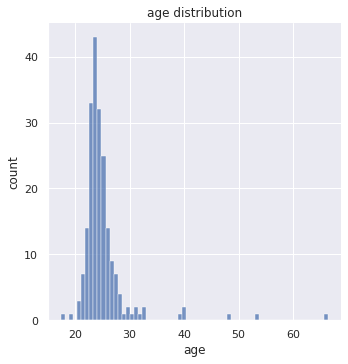

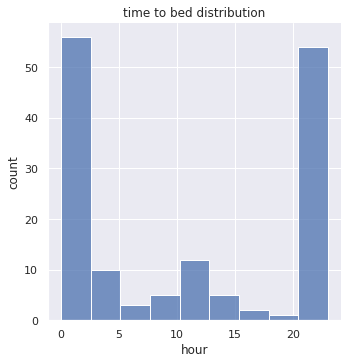

<Figure size 432x288 with 0 Axes>

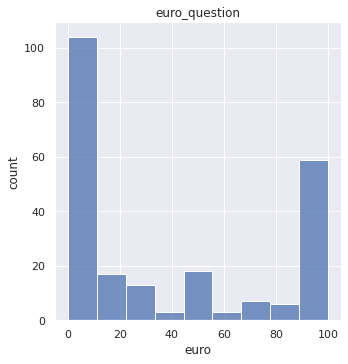

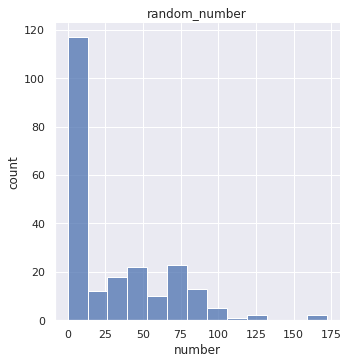

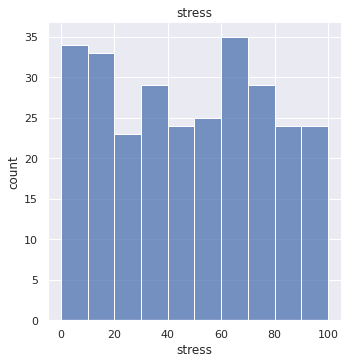

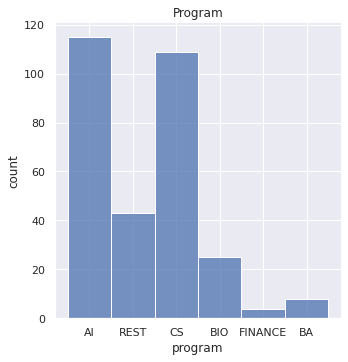

In [55]:
ax = sns.displot(data = odi_df, x='age')
plt.title('age distribution')
plt.xlabel('age')
plt.ylabel('count')

sns.displot(data = odi_df, x='time_to_bed')
plt.title('time to bed distribution')
plt.xlabel('hour')
plt.ylabel('count')
plt.figure(3)

sns.displot(data = odi_df, x='euro_question')
plt.title('euro_question')
plt.xlabel('euro')
plt.ylabel('count')

plt.figure(4)
sns.displot(data = odi_df, x='random_number')
plt.title('random_number')
plt.xlabel('number')
plt.ylabel('count')

plt.figure(5)
sns.displot(data = odi_df, x='stress')
plt.title('stress')
plt.xlabel('stress')
plt.ylabel('count')

plt.figure(6)
sns.displot(data = odi_df, x='program')
plt.title('Program')
plt.xlabel('program')
plt.ylabel('count')






<AxesSubplot:ylabel='Chocolate_influence'>

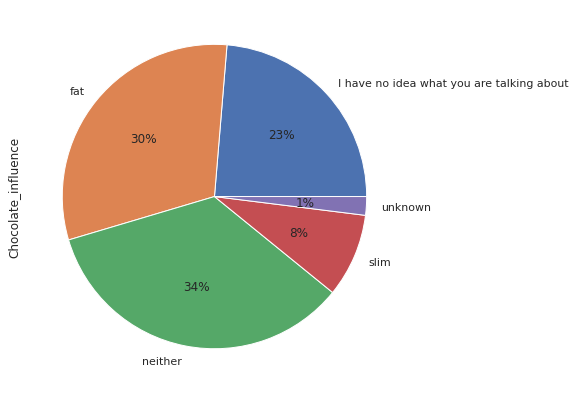

In [47]:



odi_df.groupby('Chocolate_influence')['Chocolate_influence'].count().plot.pie(autopct='%d%%',figsize=(7,7))


### Gender distribution

<AxesSubplot:ylabel='Gender'>

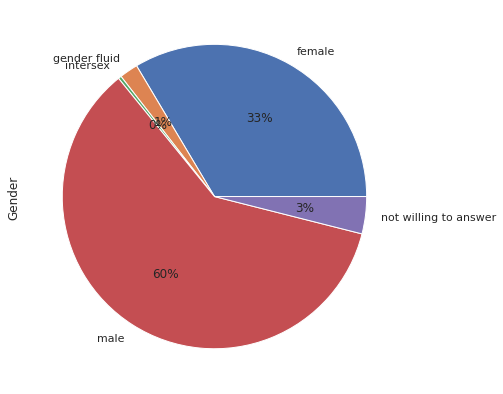

In [48]:
#display(odi_df.groupby('Gender')['Gender'].count())
odi_df.groupby('Gender')['Gender'].count().plot.pie(autopct='%d%%',figsize=(7,7))
#mask = (odi_df['Gender']!='male') & (odi_df['Gender']!='female')
#odi_df['Gender'].loc[mask]
#sns.displot(data=odi_df,x='Gender')


### correlations

In [49]:
odi_df.corr(method ='pearson')

,neighbors,stress,euro_question,random_number,time_to_bed,age
neighbors,1.000000,0.064969,0.097266,-0.019406,0.227715,0.032794
stress,0.064969,1.000000,0.066385,0.034167,-0.091989,-0.055480
euro_question,0.097266,0.066385,1.000000,0.018520,0.042700,0.163603
random_number,-0.019406,0.034167,0.018520,1.000000,0.005394,-0.065868
time_to_bed,0.227715,-0.091989,0.042700,0.005394,1.000000,-0.023278
age,0.032794,-0.055480,0.163603,-0.065868,-0.023278,1.000000


### correlations


<AxesSubplot:xlabel='program', ylabel='stress'>

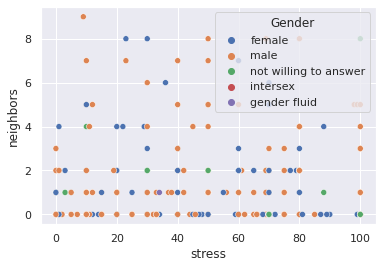

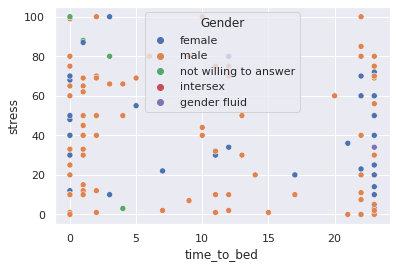

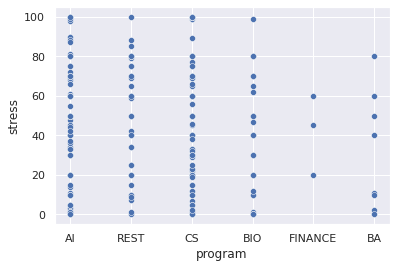

In [59]:
plt.figure(1)

sns.scatterplot(data=odi_df,x='stress', y='neighbors', hue='Gender')
plt.figure(2)

sns.scatterplot(data=odi_df,x='time_to_bed', y='stress', hue='Gender')
plt.figure(3)

sns.scatterplot(data=odi_df,x='program', y='stress')



### Pie chart of Gender put None as random number - no rule obeing 

Text(0.5, 1.0, 'gender distribution for correct data in random number')

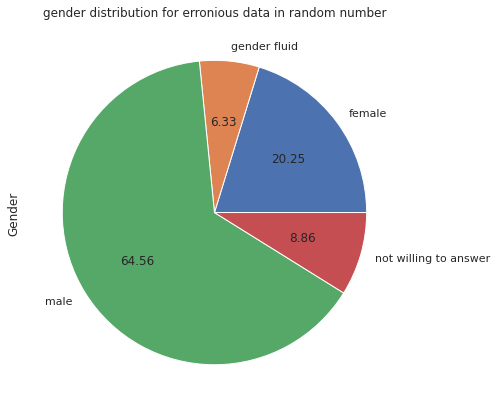

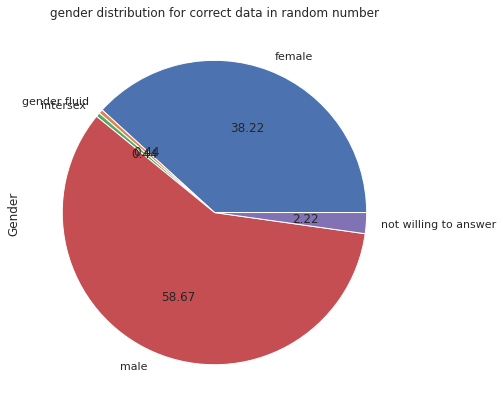

In [51]:
plt.figure(1)
odi_df[['Gender']].loc[odi_df['random_number'] .isna()].groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
plt.title('gender distribution for erronious data in random number')

plt.figure(2)
odi_df[['Gender']].loc[odi_df['random_number'] .isna()==False].groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
plt.title('gender distribution for correct data in random number')


### Good day distribution

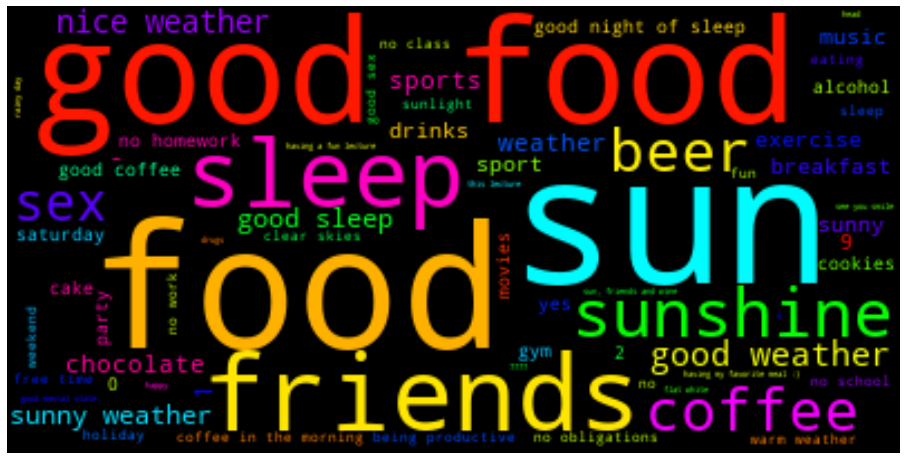

In [52]:
dictionary=Counter(list(odi_df['good_day_1'].map(str.lower))+list(odi_df['good_day_2'].map(str.lower)))
#dd = pd.DataFrame(dictionary, index=dictionary.keys)
#display(dd)
#sns.distplot( , x=index)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(dictionary)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [53]:
frequent_itemsets= apriori(odi_df[['ML','IR','DB']], min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [54]:
print(rules)

   antecedents consequents  antecedent support  consequent support   support  \
0         (ML)        (IR)            0.628289            0.269737  0.223684   
1         (IR)        (ML)            0.269737            0.628289  0.223684   
2         (ML)        (DB)            0.628289            0.539474  0.384868   
3         (DB)        (ML)            0.539474            0.628289  0.384868   
4         (IR)        (DB)            0.269737            0.539474  0.223684   
5         (DB)        (IR)            0.539474            0.269737  0.223684   
6     (ML, IR)        (DB)            0.223684            0.539474  0.190789   
7     (ML, DB)        (IR)            0.384868            0.269737  0.190789   
8     (IR, DB)        (ML)            0.223684            0.628289  0.190789   
9         (ML)    (IR, DB)            0.628289            0.223684  0.190789   
10        (IR)    (ML, DB)            0.269737            0.384868  0.190789   
11        (DB)    (ML, IR)            0.